# Evaluation of Graph Neural Network segment classifier

In [22]:
%pwd

'/global/u2/s/sfarrell/WorkAreas/trackml/heptrkx-gnn-tracking/notebooks'

In [23]:
# Concurrency config
import os
os.environ['OMP_NUM_THREADS'] = '4'

In [24]:
# Notebook utils
from nb_utils import (get_test_data_loader, load_config, load_summaries,
                      load_model, apply_model, compute_metrics,
                      plot_train_history, draw_sample, plot_metrics)

In [25]:
%matplotlib inline

In [26]:
# Config path
config_file = '../configs/agnn.yaml'

In [27]:
!cat $config_file

output_dir: ${SCRATCH}/heptrkx/results/agnn_001

trainer:
    name: gnn_sparse

data:
    name: hitgraphs_sparse
    input_dir: ${SCRATCH}/heptrkx/data/hitgraphs_high_000
    n_train: 49152
    n_valid: 4096
    real_weight: 5 #6.25  # 0.5 / 0.08
    batch_size: 4
    n_workers: 4

model:
    name: agnn
    input_dim: 3
    hidden_dim: 64
    n_graph_iters: 8
    layer_norm: true
    loss_func: binary_cross_entropy_with_logits

optimizer:
    name: Adam #SGD
    #momentum: 0.9
    learning_rate: 0.001
    lr_scaling: sqrt
    lr_warmup_epochs: 5
    lr_decay_schedule:
        - {start_epoch: 16, end_epoch: 32, factor: 0.1}
        - {start_epoch: 32, end_epoch: 64, factor: 0.01}

training:
    n_epochs: 64


In [28]:
config = load_config(config_file)
summaries = load_summaries(config)

/global/u2/s/sfarrell/WorkAreas/trackml/heptrkx-gnn-tracking/notebooks/nb_utils.py:33: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(f)


In [29]:
config

{'output_dir': '${SCRATCH}/heptrkx/results/agnn_001',
 'trainer': {'name': 'gnn_sparse'},
 'data': {'name': 'hitgraphs_sparse',
  'input_dir': '${SCRATCH}/heptrkx/data/hitgraphs_high_000',
  'n_train': 49152,
  'n_valid': 4096,
  'real_weight': 5,
  'batch_size': 4,
  'n_workers': 4},
 'model': {'name': 'agnn',
  'input_dim': 3,
  'hidden_dim': 64,
  'n_graph_iters': 8,
  'layer_norm': True,
  'loss_func': 'binary_cross_entropy_with_logits'},
 'optimizer': {'name': 'Adam',
  'learning_rate': 0.001,
  'lr_scaling': 'sqrt',
  'lr_warmup_epochs': 5,
  'lr_decay_schedule': [{'start_epoch': 16, 'end_epoch': 32, 'factor': 0.1},
   {'start_epoch': 32, 'end_epoch': 64, 'factor': 0.01}]},
 'training': {'n_epochs': 64}}

In [30]:
summaries

,lr,train_loss,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.00100,0.311542,0,1494.670187,0.169248,0.925674,58.839868
1,0.00100,0.138564,1,1488.510759,0.085495,0.969584,57.275952
2,0.00100,0.088346,2,1488.456320,0.070017,0.976182,57.918634
3,0.00100,0.076166,3,1488.227625,0.062344,0.979294,56.906239
4,0.00100,0.067371,4,1488.159731,0.058193,0.981448,57.926392
5,0.00100,0.063045,5,1490.105276,0.067720,0.977379,57.640735
6,0.00100,0.061111,6,1488.594837,0.054896,0.982462,57.612746
7,0.00100,0.059334,7,1490.764547,0.047853,0.985431,57.622647
8,0.00100,0.058033,8,1488.807183,0.052978,0.982822,57.454336
9,0.00100,0.057726,9,1489.356293,0.047492,0.985130,58.245165


## Plot the Training loss and accuracy

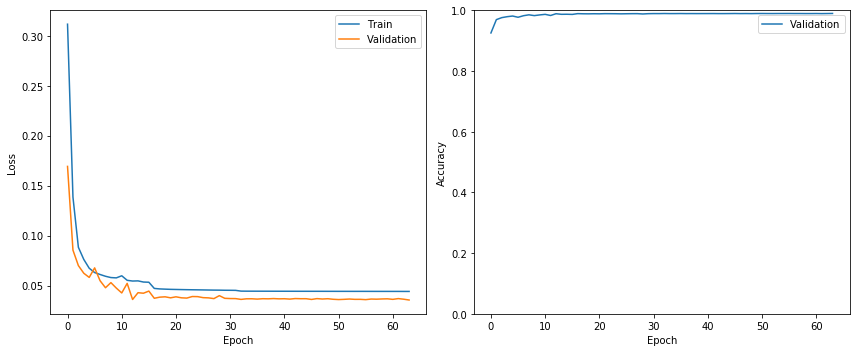

In [31]:
plot_train_history(summaries)

## Load the trained model

In [32]:
# Find the best epoch
best_summary = summaries.loc[[summaries.valid_loss.idxmin()]]
best_summary

,lr,train_loss,epoch,train_time,valid_loss,valid_acc,valid_time
63,0.00001,0.044164,63,1488.837783,0.035579,0.989925,57.580536


In [33]:
# Load model from best epoch
model = load_model(config, reload_epoch=best_summary.epoch).eval()

print(model)
print('Parameters: %i' % sum(p.numel() for p in model.parameters()))

GNNSegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=134, out_features=64, bias=True)
      (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (8): Tanh()
      (9): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=201, out_features=64, bias=True)
      (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    

## Load the test data set

In [34]:
import torch
from torch.utils.data import Subset, DataLoader

from torch_geometric.data import Batch

from datasets.hitgraphs_sparse import HitGraphDataset

from nb_utils import get_input_dir

def get_dataset(config):
    return HitGraphDataset(get_input_dir(config))

def get_test_data_loader(config, n_test=16):
    # Take the test set from the back
    full_dataset = get_dataset(config)
    test_indices = len(full_dataset) - 1 - torch.arange(n_test)
    test_dataset = Subset(full_dataset, test_indices)
    return DataLoader(test_dataset, batch_size=1, collate_fn=Batch.from_data_list)

In [35]:
n_test = 64
test_loader = get_test_data_loader(config, n_test=n_test)

## Evaluate the model on the test dataset

In [36]:
import torch

@torch.no_grad()
def apply_model(model, data_loader):
    preds, targets = [], []
    for batch in data_loader:
        preds.append(torch.sigmoid(model(batch)).squeeze(0))
        targets.append(batch.y.squeeze(0))
    return preds, targets

In [37]:
%%time
test_preds, test_targets = apply_model(model, test_loader)

CPU times: user 3min 25s, sys: 2.63 s, total: 3min 27s
Wall time: 52.5 s


In [38]:
threshold = 0.5
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.5
Accuracy:  0.9898
Precision: 0.8980
Recall:    0.9688


In [39]:
threshold = 0.6
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.6
Accuracy:  0.9916
Precision: 0.9221
Recall:    0.9645


In [40]:
threshold = 0.7
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.7
Accuracy:  0.9928
Precision: 0.9425
Recall:    0.9591


In [41]:
threshold = 0.8
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.8
Accuracy:  0.9938
Precision: 0.9610
Recall:    0.9520


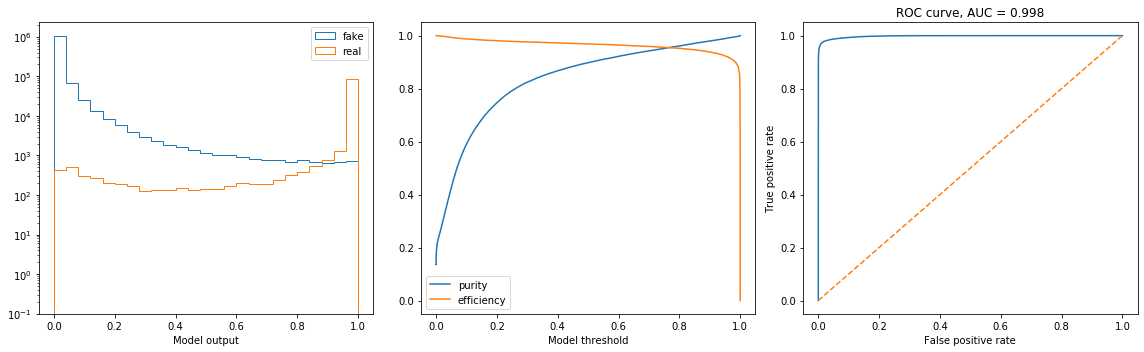

In [42]:
plot_metrics(test_preds, test_targets, test_metrics)

## Visualize predictions

TODO: update for sparse graph data structures